<a href="https://colab.research.google.com/github/C0RD3LL/Omics/blob/main/CopyPasta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analysis of single cell RNA-Seq data 





In [ ]:
# --quiet / -q silences output 
pip install -q scanpy

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import scanpy as sc
import seaborn as sns

from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

%matplotlib inline

This journal goes over basic eda of single-cell RNASeq data start to finish. The example provided is from the Tabula Muris.

In [ ]:
def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

download_and_unzip("https://github.com/chanzuckerberg/scRNA-python-workshop/raw/master/content/data.zip")

In [ ]:
brain_counts_df = pd.read_csv("/content/brain_counts.csv",index_col= 0 )
display(brain_counts_df.head())
print("DF shape: ", brain_counts_df.shape)

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,0610010O12Rik,0610011F06Rik,0610011L14Rik,0610012G03Rik,0610012H03Rik,0610030E20Rik,0610031J06Rik,0610031O16Rik,0610037L13Rik,0610037P05Rik,0610038B21Rik,0610038L08Rik,0610039K10Rik,0610040B10Rik,0610040F04Rik,0610040J01Rik,0610043K17Rik,0910001L09Rik,100043387,1100001G20Rik,1110001A16Rik,1110001J03Rik,1110002B05Rik,1110002L01Rik,...,Zranb3,Zrsr1,Zrsr2,Zscan10,Zscan12,Zscan18,Zscan2,Zscan20,Zscan21,Zscan22,Zscan29,Zscan4a,Zscan4b,Zscan4c,Zscan4d,Zscan4e,Zscan4f,Zscan5b,Zswim1,Zswim2,Zswim3,Zswim4,Zswim5,Zswim6,Zswim7,Zufsp,Zw10,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene
A1.B003290.3_38_F.1.1,0,125,16,0,0,0,0,0,0,0,0,0,8,0,0,66,140,218,0,110,0,0,155,0,0,37,0,0,0,0,0,0,0,0,0,0,0,30,107,0,...,0,0,0,0,35,0,0,0,0,9,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,0
A1.B003728.3_56_F.1.1,0,0,0,0,0,324,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,722,0,0,0,0,0,0,0,0,0,0,128,1,0,0,0,0,0,...,0,0,0,0,822,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A1.MAA000560.3_10_M.1.1,0,348,0,0,0,5,0,0,0,0,316,0,0,0,0,1,371,333,0,0,0,0,439,0,0,49,0,0,0,0,0,0,44,67,0,0,0,46,587,0,...,0,6,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,266,0,0,0,0,0,0,195,0,0,113,0
A1.MAA000564.3_10_M.1.1,0,41,36,0,0,24,0,0,0,14,0,0,3,0,0,6,11,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,0,0,8,1,62,0,...,0,0,8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,16,0,2,0,0,0,0,0,0,0,125,0,1,0,0,0
A1.MAA000923.3_9_M.1.1,0,53,0,0,0,0,0,0,0,0,0,0,3,0,0,19,118,39,0,175,0,0,20,0,0,124,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,81,0,0,0,0,0,0


DF shape:  (3401, 23433)


The column names shown represent genes. While the rows represent unique cell indentifiers that were created by the dataset author. 

To further get a better understand of the data we can read the metadata provided by the author.

In [ ]:
brain_metadata = pd.read_csv("/content/brain_metadata.csv",index_col= 0)
display(brain_metadata.head())
print("DF shape: ", brain_metadata.shape)

,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode
cell,,,,,
A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290
A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728
A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560
A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564
A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923


DF shape:  (3401, 5)


In [ ]:
print("Subtissue types: ",brain_metadata.subtissue.unique())
print("Ontology Classes:" ,brain_metadata.cell_ontology_class.unique())

Subtissue types:  ['Striatum' 'Cortex' 'Hippocampus' 'Cerebellum']
Ontology Classes: ['astrocyte' 'oligodendrocyte' 'endothelial cell' 'neuron'
 'oligodendrocyte precursor cell' 'Bergmann glial cell' 'brain pericyte']


AnnData stands for "annotated data," and is the standard format used by the analysis library, SCANPY.

AnnData uses some generalized vocabulary to describe cells and genes: they refer to cells as observations and genes as variables. This data structure has four areas where we can store information

1. Store count matrix ( AnnData.X)
2. sotre matadata info (AnnData.obs) 
3. store metadata about gene (AnnData.var)
4. sotres unstre=uctured info (AnnData.uns) 

In [ ]:
adata = sc.AnnData(X = brain_counts_df, obs = brain_metadata)
display(adata)

AnnData object with n_obs × n_vars = 3401 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'

Because this is smartseq2 data, we may have spike-ins. These gene names start with ERCC. We can label them in adata.var as a gene annotation.

In [ ]:
is_spike_in = {}
number_of_spike_ins = 0

for gene_name in adata.var_names:
    if 'ERCC' in gene_name:
        is_spike_in[gene_name] = True # record that we found a spike-in
        number_of_spike_ins += 1 # bump the counter
    else:
        is_spike_in[gene_name] = False # record that this was not a spike-in
        
adata.var['ERCC'] = pd.Series(is_spike_in) # because the index of adata.var and the keys of is_spike_in match, anndata will take care of matching them up
print('found this many spike ins: ', number_of_spike_ins)


found this many spike ins:  92


In [ ]:
#adata.write("/content/brain_raw.h5ad")
#adata = sc.read('/content/brain_raw.h5ad')

#Quality Control

Since we have our expression matrix, we need to remove poor quality cells which were not detected in the initial processing of the raw reads. Failure to remove  may add technical noise which obscures the biological signals of interest in the downstream analysis.

To perform QC we will be looking for cells which are outliers with respect to the rest of the dataset rather than comparing to independent quality standards. Consequently, care should be taken when comparing quality metrics across datasets collected using different protocols.

In [26]:
#The calculate_qc_metrics function returns two dataframes: one containing quality control metrics about cells, 
#nd one containing metrics about genes.This function is housed in the 'preprocessing' portion of the SCANPY library
#Returns (cell_qc_dataframe, gene_qc_dataframe) or (qc[0],qc[1])

qc = sc.pp.calculate_qc_metrics(adata, qc_vars= ['ERCC'])
display(qc[0].head())
print(qc[0].shape)

cell_qc_dataframe = qc[0]
gene_qc_dataframe = qc[1]

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_ERCC,log1p_total_counts_ERCC,pct_counts_ERCC
cell,,,,,,,,,,,
A1.B003290.3_38_F.1.1,3359,8.119696,390075.0,12.874097,25.884766,32.847017,42.219573,59.472666,10201.0,9.230339,2.615138
A1.B003728.3_56_F.1.1,1718,7.449498,776439.0,13.562474,43.051933,52.912721,65.313309,87.315423,67351.0,11.117688,8.674345
A1.MAA000560.3_10_M.1.1,3910,8.271548,1616087.0,14.295519,44.066006,51.514553,60.164211,74.451190,29870.0,10.304644,1.848292
A1.MAA000564.3_10_M.1.1,4352,8.378621,360004.0,12.793873,41.650926,48.958623,56.997422,69.736170,2592.0,7.860571,0.719992
A1.MAA000923.3_9_M.1.1,2248,7.718241,290282.0,12.578611,63.392494,69.136908,77.168753,90.522320,11002.0,9.305923,3.790107


(3401, 11)


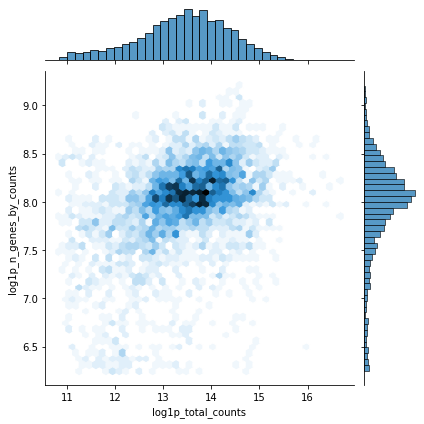

In [ ]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["ERCC"], inplace=True)
sns.jointplot(
    data=adata.obs,
    x="log1p_total_counts",
    y="log1p_n_genes_by_counts",
    kind="hex")

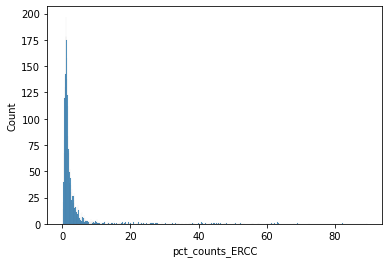

In [30]:
sns.histplot(adata.obs['pct_counts_ERCC'],bins = 1000)

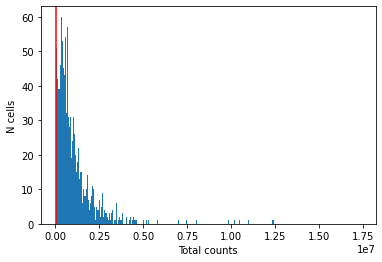

In [28]:
plt.hist(cell_qc_dataframe['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('N cells')
plt.axvline(50000, color='red')

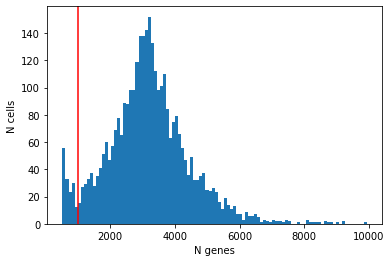

In [29]:
plt.hist(cell_qc_dataframe['n_genes_by_counts'], bins=100)
plt.xlabel('N genes')
plt.ylabel('N cells')
plt.axvline(1000, color='red')

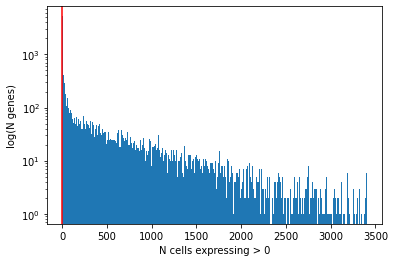

In [27]:
plt.hist(gene_qc_dataframe['n_cells_by_counts'], bins=1000)
plt.xlabel('N cells expressing > 0')
plt.ylabel('log(N genes)') # for visual clarity
plt.axvline(2, color='red')
plt.yscale('log') 